# Question 3 -  Classifying the finding of a complaint investigation
#### Mihir Bhaskar
#### 11/23/2021

This file does the following. It is organised as numbered sections, which match the ordering provided below:

0. Research Question Motivation


1. Data Import, Processing and Exploration. This file imports and merges two datasets:
    - 'CleanComplaints_FindingLevel.csv', which is a file created by 3_CleanComplaints.ipynb. This is a cleaned .csv file at the complaint-officer level from 2015-2018, along with relevant info about the complaint. Importantly, this has the target variable: what the final outcome/finding was from the complaint. 
    - 'Combined.csv', which is a file containing all the tract-level features used in previous analysis
    
    
2. Variable selection and description
    - This section checks for correlations between variables, and once we find that there are a lot of variables with high correlation, runs a function to identify variables that contribute >5.0 to the Variance Inflation Factor
    
    
3. Model training and selection. Runs several classification models to classify 'sustained' vs 'not sustained' as the finding.
    - Subsections 3.1 to 3.4 run two different models under each of the following classification algorithms: Naive Bayes, KNN, Decision Tree, Random Forest. One model is using the full set of features, and the second model is using only the features that do not add a lot ot the Variance Inflation Factor (to account for multicollinearity)
    - Subsection 3.5 then uses ROC/AUC to select the best method
    
4. Model Tuning, Validation, and Results
    - Subsection 4.1 tunes the best chosen model (Random Forest, tuned with GridSearch) and displays the results from the validation
    - Subsection 4.2 looks at feature importance
    
    
5. Conclusions and Discussions

    
6. Appendix - code from other modelling efforts done, but were not found to be worthy of further investigation
    - Appendix A - An attempt to run kitchen-sink models that uses all possible classes of 'Finding'
    - Appendix B - An attempt to classify sustained vs. all other categories

In [211]:
# Importing libraries
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px

from pyprojroot import here

from statsmodels.stats.outliers_influence import variance_inflation_factor   
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split, LeaveOneOut, KFold, cross_val_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn import metrics
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
from sklearn import preprocessing
from sklearn import neighbors
from sklearn.metrics import r2_score 
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
import pydot
from yellowbrick.features import RadViz
import graphviz
from graphviz import Source
from sklearn import tree
from IPython.display import Image
from sklearn.tree import DecisionTreeRegressor, DecisionTreeClassifier, export_graphviz
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier, BaggingRegressor 
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import mean_squared_error, confusion_matrix, classification_report
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from dtreeviz.trees import dtreeviz
from sklearn.linear_model import LogisticRegression 

## 0. Research Question Motivation

The research question I address in this file is: **What dictates the outcome of a complaint? Can we classify these outcomes?**. 


This question builds on the previous modelling efforts by asking a question one level further. While the previous questions focused on whether a complaint is registered at all, this investigates what happens with those complaints. If complaints are not taken seriously or acted upon, this has implications for whether people file complaints in the first place, and has implications for the police force when understanding the bias of internal investigations.

## 1. Data Import, Processing and Exploration

In [212]:
# Importing complaint-level data
df = pd.read_csv(here('./data/CleanComplaints_FindingLevel.csv'))

df.head()

,CRID,OfficerID,Allegation,Finding,Outcome,Beat,IncidentDate,StartDate,EndDate,InvestigatorRank,...,physical_violence,injury,weapon,on_duty,officer_white,witness_white,officer_male,witness_male,officer_cmp_count,incident_year
0,1073326,18560,Unnecessary Display Of Weapon / Off Duty,No Affidavit,No Action Taken,621.0,2015-01-01,2015-01-12,2015-09-14,NaN,...,0,0,1,0,1,0,1,0,0,2015
1,1073326,24186,Unnecessary Display Of Weapon / Off Duty,No Affidavit,No Action Taken,621.0,2015-01-01,2015-01-12,2015-09-14,NaN,...,0,0,1,0,1,0,1,0,0,2015
2,1073326,18571,Unnecessary Display Of Weapon / Off Duty,No Affidavit,No Action Taken,621.0,2015-01-01,2015-01-12,2015-09-14,NaN,...,0,0,1,0,1,0,1,0,0,2015
3,1073326,32099,Unnecessary Display Of Weapon / Off Duty,No Affidavit,No Action Taken,621.0,2015-01-01,2015-01-12,2015-09-14,NaN,...,0,0,1,0,0,0,1,0,0,2015
4,1073326,14476,Unnecessary Display Of Weapon / Off Duty,No Affidavit,No Action Taken,621.0,2015-01-01,2015-01-12,2015-09-14,NaN,...,0,0,1,0,1,0,1,0,0,2015


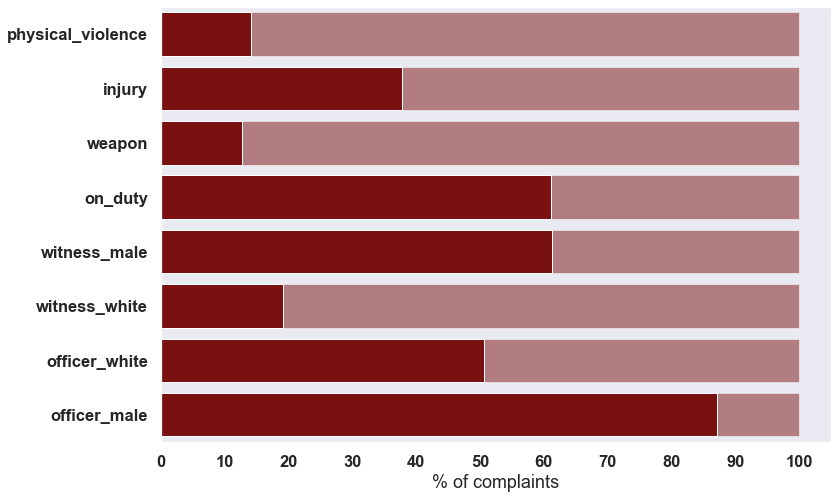

,officer_cmp_count,officer_rank_order,officer_age
count,1180.00000,1174.000000,1174.000000
mean,0.15339,1.149915,45.750426
std,0.45234,0.404172,8.194767
min,0.00000,1.000000,26.000000
25%,0.00000,1.000000,39.000000
50%,0.00000,1.000000,45.000000
75%,0.00000,1.000000,52.000000
max,4.00000,4.000000,68.000000


In [213]:
# Describing complaint characteristics

# Stacked proportion bar chart for dummy variables

## Creating data for graph
graph = df[['physical_violence', 'injury', 'weapon', 'on_duty', 'witness_male', 'witness_white', 
    'officer_white', 'officer_male']].mean()

graph = pd.DataFrame(data=graph, columns={'Mean'})

graph.reset_index(inplace=True)

graph['Mean'] = 100*graph['Mean']
graph['Remaining'] = 100 


## Drawing the plot 
plt.figure(figsize=(12, 8))
sns.set(font_scale = 1.5)
bar1 = sns.barplot(y='index', x='Remaining', data=graph, color='darkred', alpha=0.5)
bar2 = sns.barplot(y='index', x='Mean', data=graph, color='darkred')
plt.xlabel('% of complaints')
plt.ylabel('')
plt.xticks(range(0, 101, 10))
plt.grid(False)
plt.show()

# Showing descriptive stats for the numeric variables
df[['officer_cmp_count', 'officer_rank_order', 'officer_age']].describe()


Descriptive results:
- **Nature of allegation**: 14% of complaints involved physical violence, 38% led to some form of injury, 13% involved a weapon (display or use), 61% happened while on duty

- **Characteristics of witness/complainant**: 61% of witnesses were male, 19% were white

- **Characteristics of officer**: 51% of officers facing complaints are white, 87% male, almost no officers have had a history of complaints (i.e. appear only once in the dataset), are on average at the lowest levle of police (i.e. regular police officers), and are on average 46 years of age. 

In [214]:
# Merging on census tract-level features, stored in the 'Combined' dataset
# Note: these tract-level features have already been described in a previous file, so no need to describe them again here
tractlevel = pd.read_csv(here('./data/Combined.csv'))

print(f'Number of rows before merging on tract-level features: {len(df)}')
df = df.merge(tractlevel, how='left', on=['geo_id'])
print(f'Number of rows after merging on tract-level features: {len(df)}')


Number of rows before merging on tract-level features: 1180
Number of rows after merging on tract-level features: 1180


In [215]:
# Drop columns that are not used (e.g. text fields, IDs) or have already been converted into dummy variables
df.drop(columns=['OfficerID', 'Allegation', 'Outcome', 'Beat', 'IncidentDate', 'StartDate', 'EndDate',
                'InvestigatorRank', 'officer_appt_date', 'officer_race', 'officer_gender',
                 'witness_race', 'witness_gender', 'geometry', 'GEOID10', 'geo_id'], inplace=True)

## 2. Variable selection and description

In [216]:
# Describing the category we are predicting (i.e. the different potential classes)
df[['Finding', 'CRID']].groupby('Finding').count().sort_values(by='CRID', ascending = False).rename(columns = {'CRID': 'Number of complaint-officer pairs'})

,Number of complaint-officer pairs
Finding,
No Affidavit,398
Unfounded,251
Unknown,187
Not Sustained,162
Sustained,112
Exonerated,70


We see that the categories are fairly spread out, with 'no affidavit' being the most frequent. This means that the complainant did not take the case forward by signing an affidavit.

In [217]:
# Checking for correlations between features 

# Generating a correlation matrix
# Note: code below sourced from this link: https://stackoverflow.com/questions/41128456/pandas-filter-across-all-columns
corr = df.corr()

# This code keeps only the upper triangle of the correlation matrix (because the two triangles are copies/repeats)
corr_triu = corr.where(~np.tril(np.ones(corr.shape)).astype(bool))

# This reshapes the matrix to become like a stack, with Var 1, Var 2, and their respective score
corr_triu = corr_triu.stack()

# Making the output more readable
corr_triu.name = 'Correlation Coefficient'
corr_triu.index.names = ['Col1', 'Col2']

# Filtering only those values where absolute value of the correlation is > 80% (i.e. highly correlated variables)
corr_triu = corr_triu[abs(corr_triu) > 0.8].to_frame()

# Ordering from highest correlation to lowest based on absolute correlation
corr_triu.sort_values(by='Correlation Coefficient', key=pd.Series.abs, ascending=False, inplace=True)

print(f'Number of feature pairs that are highly correlated (i.e. >80%): {len(corr_triu)}')

corr_triu

Number of feature pairs that are highly correlated (i.e. >80%): 79


Correlation Coefficient
Col1                      Col2                                       
DECEPTIVE PRACTICE        THEFT                              0.986841
commercial_establishments DECEPTIVE PRACTICE                 0.968372
                          THEFT                              0.966038
DP05_0037PE               DP05_0038PE                       -0.947886
BATTERY                   OTHER OFFENSE                      0.946772
...                                                               ...
DP03_0066PE               DP05_0024PE                        0.805326
DP03_0098PE               DP05_0037PE                       -0.805021
commercial_establishments STALKING                           0.804893
DP03_0027PE               DP03_0031PE                       -0.801561
CRIM SEXUAL ASSAULT       ROBBERY                            0.800488

[79 rows x 1 columns]

There are several highly correlated features. The code below looks at using the **Variance Inflation Factor** to identify problematic multicollinear variables and remove them.

### Note - the cell below takes around 5-10 minutes to run

In [218]:
# Identify the variables that contribute disproportionately to variance inflation factor (dealing with multicollinearity)

# The code below was sourced from the following link:
# https://stats.stackexchange.com/questions/155028/how-to-systematically-remove-collinear-variables-pandas-columns-in-python

## NOTE: This cell takes a long time to run ##

# This function calculates the variance inflation factor for each column given a dataset, and returns a list of those variables that fall
# under the threshold of 5 (i.e. do not contribute large amounts to variance inflation)
def calculate_vif_(X, thresh=5.0):
    variables = list(range(X.shape[1]))
    dropped = True
    while dropped:
        dropped = False
        vif = [variance_inflation_factor(X.iloc[:, variables].values, ix)
               for ix in range(X.iloc[:, variables].shape[1])]

        maxloc = vif.index(max(vif))
        if max(vif) > thresh:
            print('dropping \'' + X.iloc[:, variables].columns[maxloc] +
                  '\' at index: ' + str(maxloc))
            del variables[maxloc]
            dropped = True

    print('Remaining variables:')
    print(X.columns[variables])
    return variables

# Based on the X feature set, get a list of variables that should be kept according to VIF

# Create a temporary X set that will be fed into the VIF function
tmp = df.drop(columns=['CRID', 'Finding']) # Dropping the y column
tmp = tmp.select_dtypes(['number']) # Selecting only numeric values
tmp = tmp.dropna() # Dropping any NA values that will break the code


# Run the VIF function, to get back a list of variables we should keep according to VIF
vif_keep = calculate_vif_(tmp, thresh=5.0)

dropping 'incident_year' at index: 11
dropping 'DP02_0010PE' at index: 15
dropping 'DP03_0027PE' at index: 51
dropping 'DP02_0067PE' at index: 33
dropping 'DP02_0016E' at index: 17
dropping 'DP03_0004PE' at index: 43
dropping 'DP05_0003PE' at index: 78
dropping 'DP03_0064PE' at index: 55
dropping 'DP02_0080PE' at index: 36
dropping 'DP05_0038PE' at index: 80
dropping 'DP05_0018E' at index: 76
dropping 'BATTERY' at index: 91
dropping 'DP02_0032PE' at index: 20
dropping 'DP02_0153PE' at index: 40
dropping 'DP02_0015PE' at index: 16
dropping 'DP05_0019PE' at index: 73
dropping 'THEFT' at index: 116
dropping 'ASSAULT' at index: 86
dropping 'DP02_0026PE' at index: 17
dropping 'DP03_0098PE' at index: 55
dropping 'DP02_0072PE' at index: 29
dropping 'DP03_0013PE' at index: 38
dropping 'CRIMINAL DAMAGE' at index: 85
dropping 'DP02_0022PE' at index: 16
dropping 'B01001_001E' at index: 11
dropping 'OTHER OFFENSE' at index: 101
dropping 'DP04_0049E' at index: 55
dropping 'DECEPTIVE PRACTICE' at in

In [219]:
print(f'The total number of columns retained by the VIF seleciton process is {len(vif_keep)}')

vif_keep = tmp.columns[vif_keep]

The total number of columns retained by the VIF seleciton process is 50


## 3. Model training and selection: sustained vs. not sustained

**Motivation for selecting the target variable**:
- We first tried classifying the model using all the classes, as an initial test. These results are presented in Appendix A. Thd model results were not very successful - we believe the reason is that there were too many categories, and too much scope for overlap in the category definitions. For example, a case that is 'unknown' could, in reality, fall into many different buckets. Similarly, a case that is 'unfounded' and 'not sustained' are likely to share many characteristics, making it difficult to separate out.


- We then tried classifying a model of sustained vs. all other categories. In this case, the labels were too unbalanced; there were only 112 'sustained' cases, against 1068 other cases. The modelling accuracy and recalll were very poor. Some of these results are presented in Appendix B.


- We decided that a model limiting the prediction to sustained vs. not sustained was suitable. There are a few reasons for this:
    - The classes are more balanced
    - There is less noise in the comparison. Sustained means that there was enough evidence to take action, and unsustained means there was insufficient evidence. Other categories such as Unfounded, Unknown, No Affidavit are slightly more unclear and have more scope for overlap
    - For the above reasons and the resulting clarity, we believe it is worth sacrificing the larger sample size to focus on just these two classes

In [220]:
# Convert 'finding' into dummy variables
df_sust = pd.get_dummies(df, columns=['Finding'])

# Dropping columns that have any NA values (otherwise the modelling will not work)
df_sust.dropna(inplace=True)

# Keep only observations where finding was either sustained or not sustained
# Other classes are somewhat noisy and difficult to model. See a very preliminary effort in the Appendix.
df_sust = df_sust[(df_sust['Finding_Sustained'] == 1) | (df_sust['Finding_Not Sustained'] == 1)]

# Dropping the other unused dummy variables created by 'finding'
df_sust.drop(columns=['Finding_Exonerated', 'Finding_No Affidavit', 'Finding_Not Sustained', 'Finding_Unfounded', 'Finding_Unknown'], inplace=True)

# Splitting the datasets up into X and Y
y = df_sust['Finding_Sustained']

X = df_sust.drop(columns=['CRID', 'Finding_Sustained'])
X = X.select_dtypes(['number']) 

# Creating a separate X set that removes the variables that contribute to VIF (i.e. keeping non collinear variables)
X_sub = X[vif_keep]

# Split into train and test, with a 80-20 split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.20, random_state = 11)         

X_sub_train, X_sub_test, y_train, y_test = train_test_split(X_sub, y, test_size=0.20, random_state = 11)



In [221]:
# Show the distribution of labels
print(df_sust[['CRID', 'Finding_Sustained']].groupby('Finding_Sustained').count())

# Define labels to use on following graphs and confusion matrices
target_names = ['Not Sustained', 'Sustained']

                   CRID
Finding_Sustained      
0                   158
1                   109


As mentioned in the justification above, while there are more cases of findings being 'not sustained', the classes are not significantly imbalanced. Hence, we proceed with the modelling efforts below.

### Note: for each of the models below, we train the model using all features, as well as a subset of features selected using the VIF criterion

### 3.1.a Naive Bayes Classification - using all features

              precision    recall  f1-score   support

           0      0.765     0.448     0.565        29
           1      0.568     0.840     0.677        25

    accuracy                          0.630        54
   macro avg      0.666     0.644     0.621        54
weighted avg      0.673     0.630     0.617        54



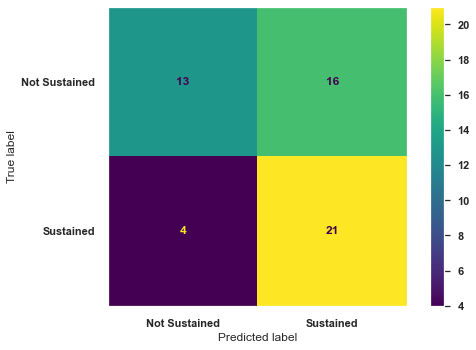

In [222]:
# Define model object
nb_full = GaussianNB()

# Fit to the training data and get predicitons
nb_full_pred = nb_full.fit(X_train,y_train).predict(X_test) 

# Print classification report
print(classification_report(y_test,nb_full_pred,digits = 3))

# Print confusion matrix
sns.set(font_scale = 1)
cm = confusion_matrix(y_test,nb_full_pred) 
display_cm = ConfusionMatrixDisplay(confusion_matrix = cm, display_labels = target_names)
display_cm = display_cm.plot()
plt.grid(b=None)

This Naive Bayes classification gives us an overlal accuracy of 63%. The recall for predicting cases that are sustained is good (84%), but it does not do well at classifying cases that were not sustained. 

### 3.1.b Naive Bayes Classification - using subset of low VIF features

              precision    recall  f1-score   support

           0      0.688     0.759     0.721        29
           1      0.682     0.600     0.638        25

    accuracy                          0.685        54
   macro avg      0.685     0.679     0.680        54
weighted avg      0.685     0.685     0.683        54



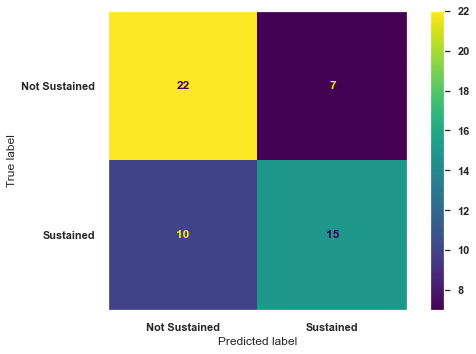

In [223]:
# Defining model
nb_sub = GaussianNB()

# Fitting using X_sub_train instead of X_train, and fitting using X_sub_test
nb_sub_pred = nb_sub.fit(X_sub_train,y_train).predict(X_sub_test) 

# Printing classification report and confusion matrix
print(classification_report(y_test,nb_sub_pred,digits = 3))

#Confusion matrix
cm = confusion_matrix(y_test, nb_sub_pred) 
display_cm = ConfusionMatrixDisplay(confusion_matrix = cm, display_labels = target_names)
display_cm.plot()
plt.grid(b=None)


This model improves on the Naive Bayes run on the full dataset, but not by much. Accuracy improves to 69%, and we have a better prediction on the 'not sustained' class, but we have a worse result on the 'Sustained' class. Overall, it seems like perhaps Naive Bayes does not perform so well because of features that are not independent. It is likely that several of the demographic features in the model are related to each other.

### 3.2.a Tuned KNN - using all features 

Below, we tune and fit a KNN model using all features

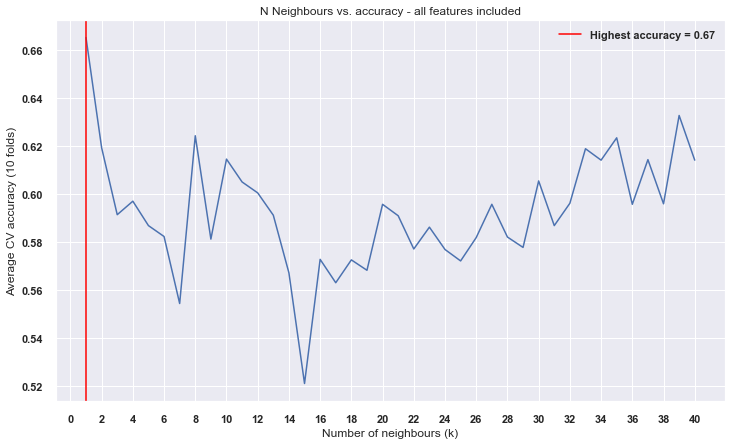

In [224]:
# Tuning KNN - finding the optimal number of neighbours based on accuracy score

avg_cv_accuracy = [] # Initialising list in which to store CV accuracy values for each 'k'

# Looping over range of possible values for k (number of neighbours)
for k in range(1,41):
    
    # Defining the model and fitting it to the data
    knn_model = KNeighborsClassifier(n_neighbors = k)
    knn_model.fit(X_train, y_train)
    
    # Getting the CV accuracy scores, and averaging for each iteration, and appending to the list defined earlier
    scores = cross_val_score(knn_model, X_train, y_train, scoring = 'accuracy', cv=10, n_jobs=-1)
    avg_cv_accuracy.append(np.mean(scores))
    
# Getting the optimal number of neighbours as the 'k' where avg. CV recall is maximised:
highest_accuracy_index = avg_cv_accuracy.index(max(avg_cv_accuracy)) + 1     
    
# Plotting the 'k' values against CV accuracy
plt.figure(figsize = (12,7))
plt.plot(range(1, 41), avg_cv_accuracy)
plt.xticks(range(0,41, 2))
plt.xlabel('Number of neighbours (k)')
plt.ylabel('Average CV accuracy (10 folds)')
plt.title('N Neighbours vs. accuracy - all features included')
plt.axis('tight')
plt.axvline(x = highest_accuracy_index, color = 'red', label = 'Highest accuracy = {:.2f}'.format(max(avg_cv_accuracy)))
plt.legend()



The optimal number of neighbours, as chosen by maximising the CV accuracy, is 1 neighbour (i.e. a simple 'nearest neighbour') algorithm. We fit this model below.

              precision    recall  f1-score   support

           0      0.697     0.793     0.742        29
           1      0.714     0.600     0.652        25

    accuracy                          0.704        54
   macro avg      0.706     0.697     0.697        54
weighted avg      0.705     0.704     0.700        54



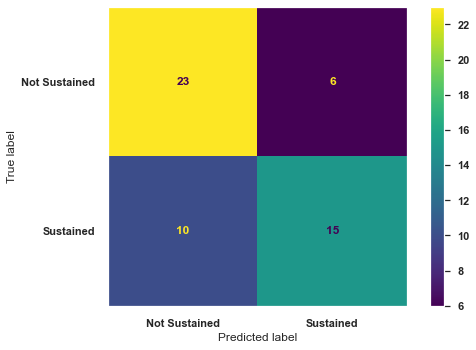

In [225]:
# Fitting the KNN model with k = 1, as selected above
knn_full = KNeighborsClassifier(n_neighbors = 1)
knn_full.fit(X_train, y_train)
knn_full_pred = knn_full.predict(X_test)

# Printing classification report 
print(classification_report(y_test, knn_full_pred, digits = 3))

# Displaying confusion matrix
cm_bc = confusion_matrix(y_test, knn_full_pred)
display_cm_bc = ConfusionMatrixDisplay(confusion_matrix=cm_bc, display_labels=target_names)
display_cm_bc.plot()
plt.grid(b=None)



This tuned KNN model on all features improves on the accuracy score of the Naive Bayes model. It appears to be better at prediction 'Not Sustained' than sustained. However, the accuracy is still not ideal, at 70%. The model could be getting skewed by irrelevant features; especially since we have >100 features in the full dataset.

### 3.2.b Tuned KNN - using subset of low VIF features 

Below, we tune and fit a KNN model using the subset of low VIF features

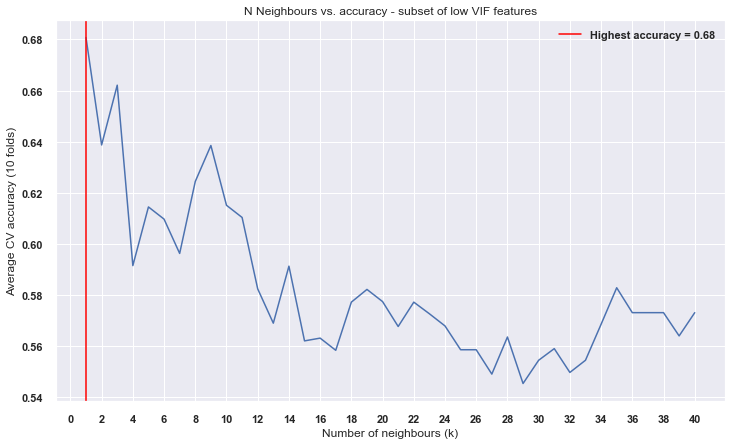

In [226]:
# Tuning KNN - finding the optimal number of neighbours based on accuracy score

avg_cv_accuracy = [] # Initialising list in which to store CV accuracy values for each 'k'

# Looping over range of possible values for k (number of neighbours)
for k in range(1,41):
    
    # Defining the model and fitting it to the data
    knn_model = KNeighborsClassifier(n_neighbors = k)
    knn_model.fit(X_sub_train, y_train)
    
    # Getting the CV accuracy scores, and averaging for each iteration, and appending to the list defined earlier
    scores = cross_val_score(knn_model, X_sub_train, y_train, scoring = 'accuracy', cv=10, n_jobs=-1)
    avg_cv_accuracy.append(np.mean(scores))
    
# Getting the optimal number of neighbours as the 'k' where avg. CV recall is maximised:
highest_accuracy_index = avg_cv_accuracy.index(max(avg_cv_accuracy)) + 1     
    
# Plotting the 'k' values against CV accuracy
plt.figure(figsize = (12,7))
plt.plot(range(1, 41), avg_cv_accuracy)
plt.xticks(range(0,41, 2))
plt.xlabel('Number of neighbours (k)')
plt.ylabel('Average CV accuracy (10 folds)')
plt.title('N Neighbours vs. accuracy - subset of low VIF features')
plt.axis('tight')
plt.axvline(x = highest_accuracy_index, color = 'red', label = 'Highest accuracy = {:.2f}'.format(max(avg_cv_accuracy)))
plt.legend()

The optimal number of neighbours, as selected by CV accuracy, is again 1. We fit this model below.

              precision    recall  f1-score   support

           0      0.750     0.724     0.737        29
           1      0.692     0.720     0.706        25

    accuracy                          0.722        54
   macro avg      0.721     0.722     0.721        54
weighted avg      0.723     0.722     0.723        54



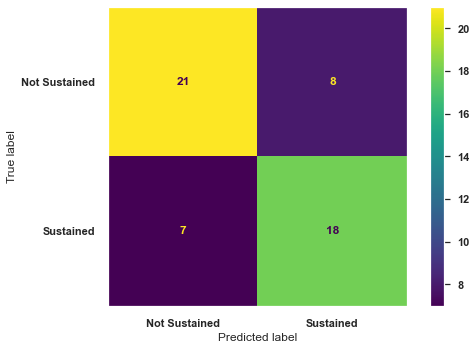

In [227]:
# Fitting the KNN model with k = 1, as selected above
knn_sub = KNeighborsClassifier(n_neighbors = 1)
knn_sub.fit(X_sub_train, y_train)
knn_sub_pred = knn_sub.predict(X_sub_test)

# Printing classification report 
print(classification_report(y_test, knn_sub_pred, digits = 3))

# Displaying confusion matrix
cm_bc = confusion_matrix(y_test, knn_sub_pred)
display_cm_bc = ConfusionMatrixDisplay(confusion_matrix=cm_bc, display_labels=target_names)
display_cm_bc.plot()
plt.grid(False)

The KNN model on the subset of features performs marginally better than the model on the full set of features. This is probably because there are fewer features, and so less potential for noisy/irrelevant variables to influence the prediction. However, we are still looking at a model of 50 features, and so it is understandable that KNN does not perform as well as we might desire (72% accuracy). 

### 3.3.a. - Decision Tree, using all features

We now try tree-based methods of classification. The hope is that trees will also be able to provide some insight about which variables are more important than others for classification.

              precision    recall  f1-score   support

           0      0.675     0.931     0.783        29
           1      0.857     0.480     0.615        25

    accuracy                          0.722        54
   macro avg      0.766     0.706     0.699        54
weighted avg      0.759     0.722     0.705        54



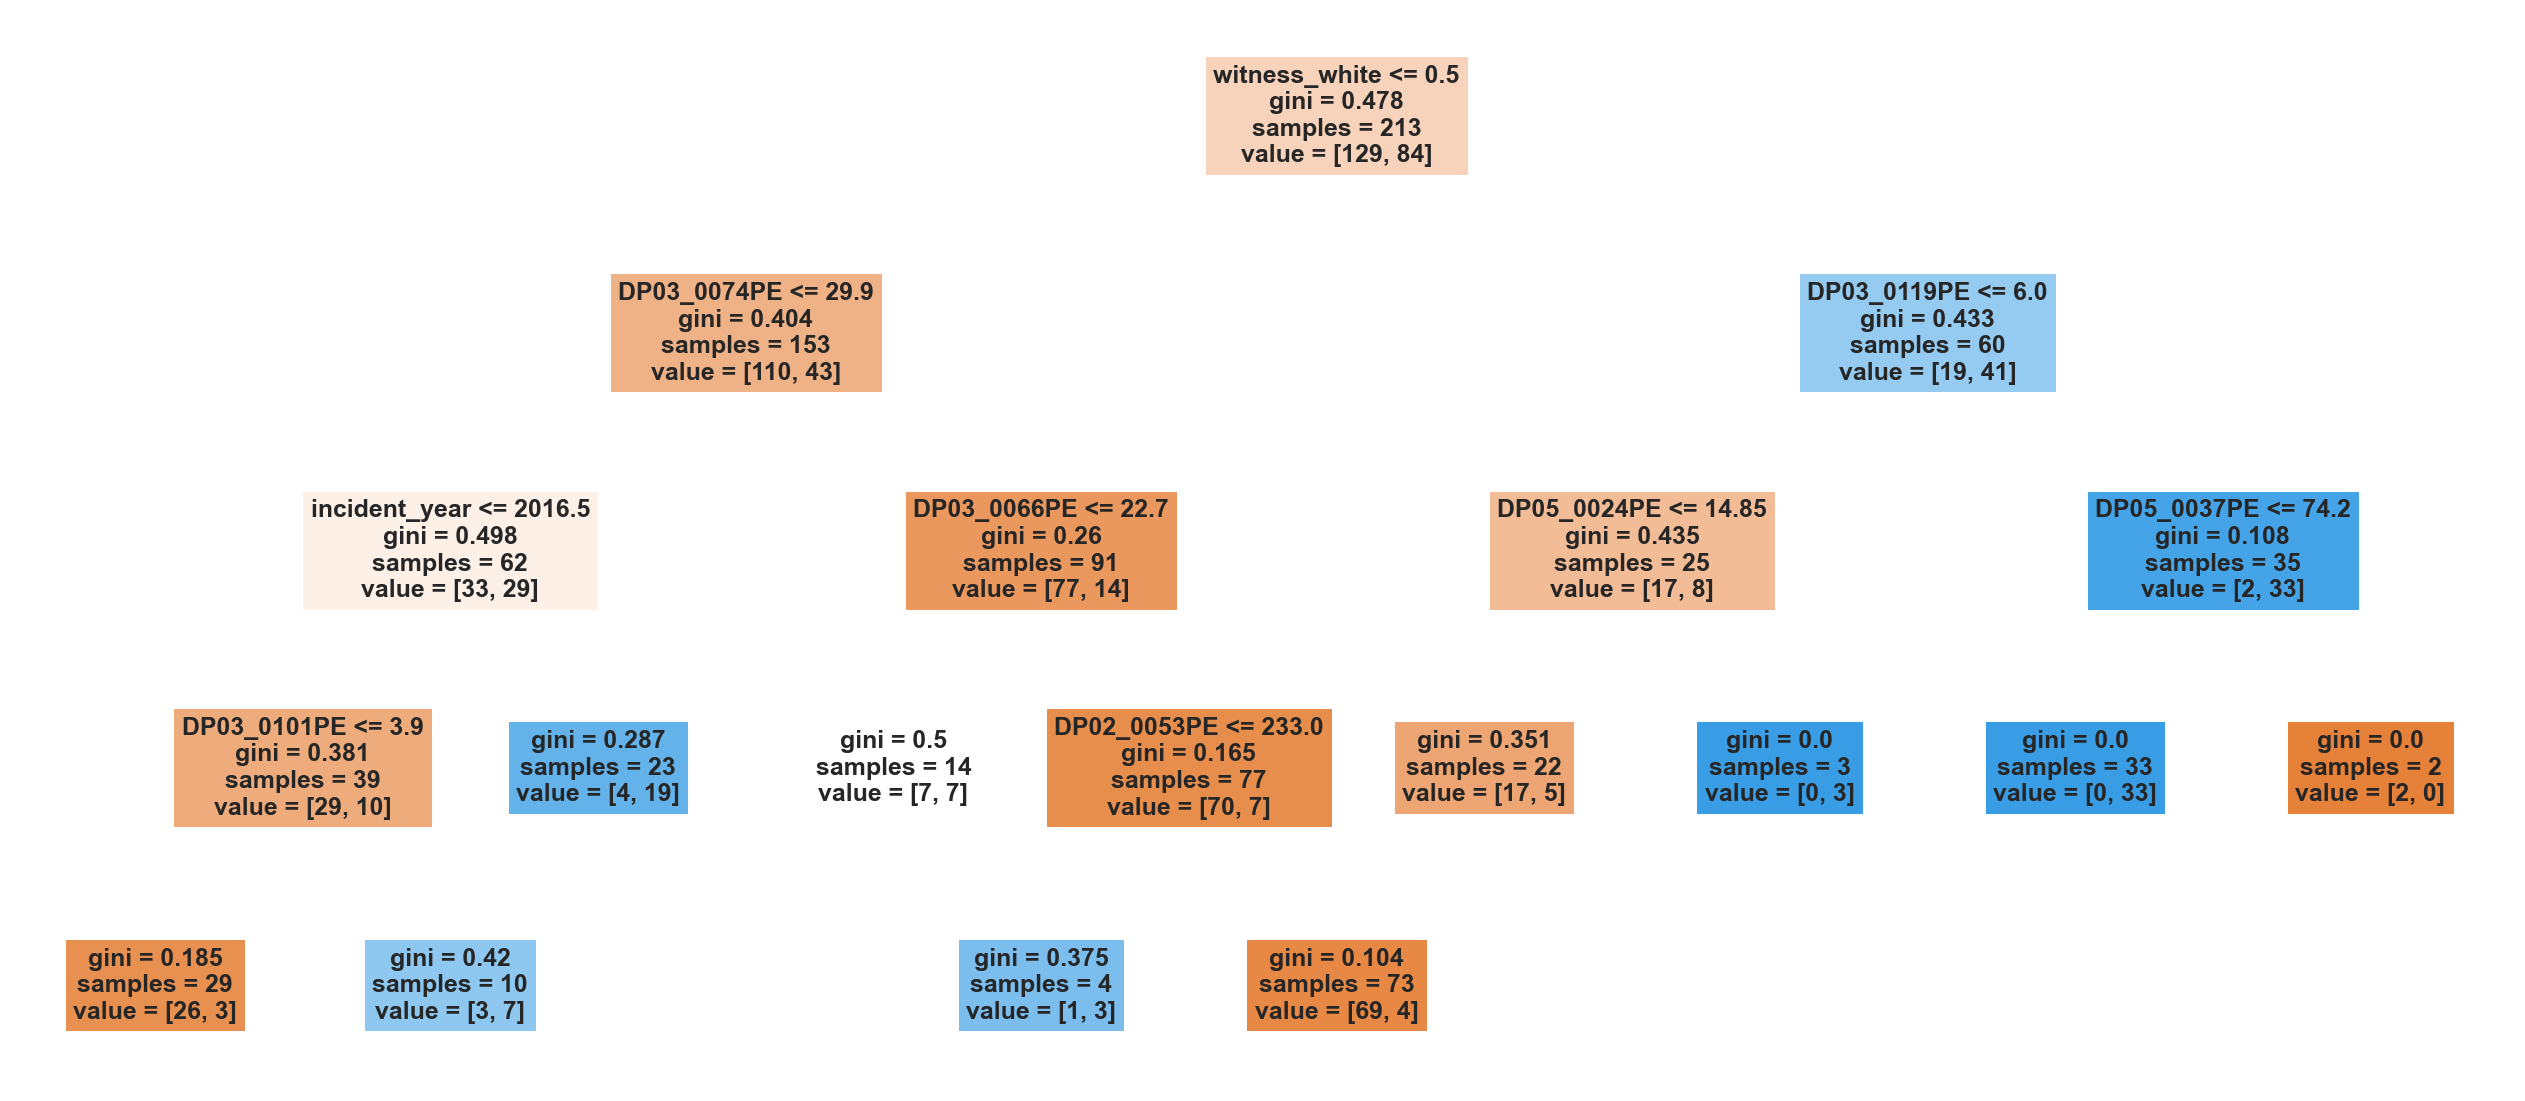

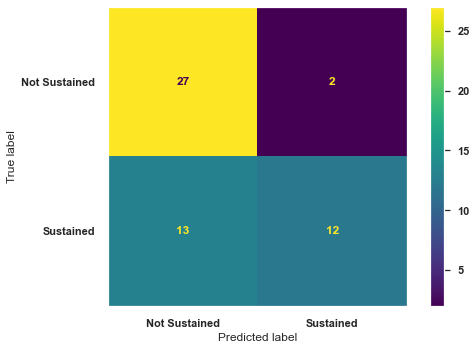

In [228]:
# Decision tree classifier
dt_full = DecisionTreeClassifier(random_state=1, max_leaf_nodes=10)
dt_full.fit(X_train, y_train)

# Plotting the tree
fig = plt.figure(figsize=(45,20))
plot_tree = tree.plot_tree(dt_full, 
                   feature_names=X_train.columns,  
                   filled=True)


dt_full_pred = dt_full.predict(X_test)

print(classification_report(y_test, dt_full_pred, digits = 3))

# Displaying confusion matrix
cm_bc = confusion_matrix(y_test, dt_full_pred)
display_cm_bc = ConfusionMatrixDisplay(confusion_matrix=cm_bc, display_labels=target_names)
display_cm_bc.plot()
plt.grid(False)

This decision tree with all the features does a great job at predicting the 'Not Sustained' class. However, it performs very poorly at classifying 'Sustained'. The overall accuracy is similar to the KNN model.

We can see from the tree that the most important feature appears to be whether the witness was white. This makes some intuitive sense. 

### 3.3.b - Decision Tree, using subset of low VIF features

              precision    recall  f1-score   support

           0      0.675     0.931     0.783        29
           1      0.857     0.480     0.615        25

    accuracy                          0.722        54
   macro avg      0.766     0.706     0.699        54
weighted avg      0.759     0.722     0.705        54



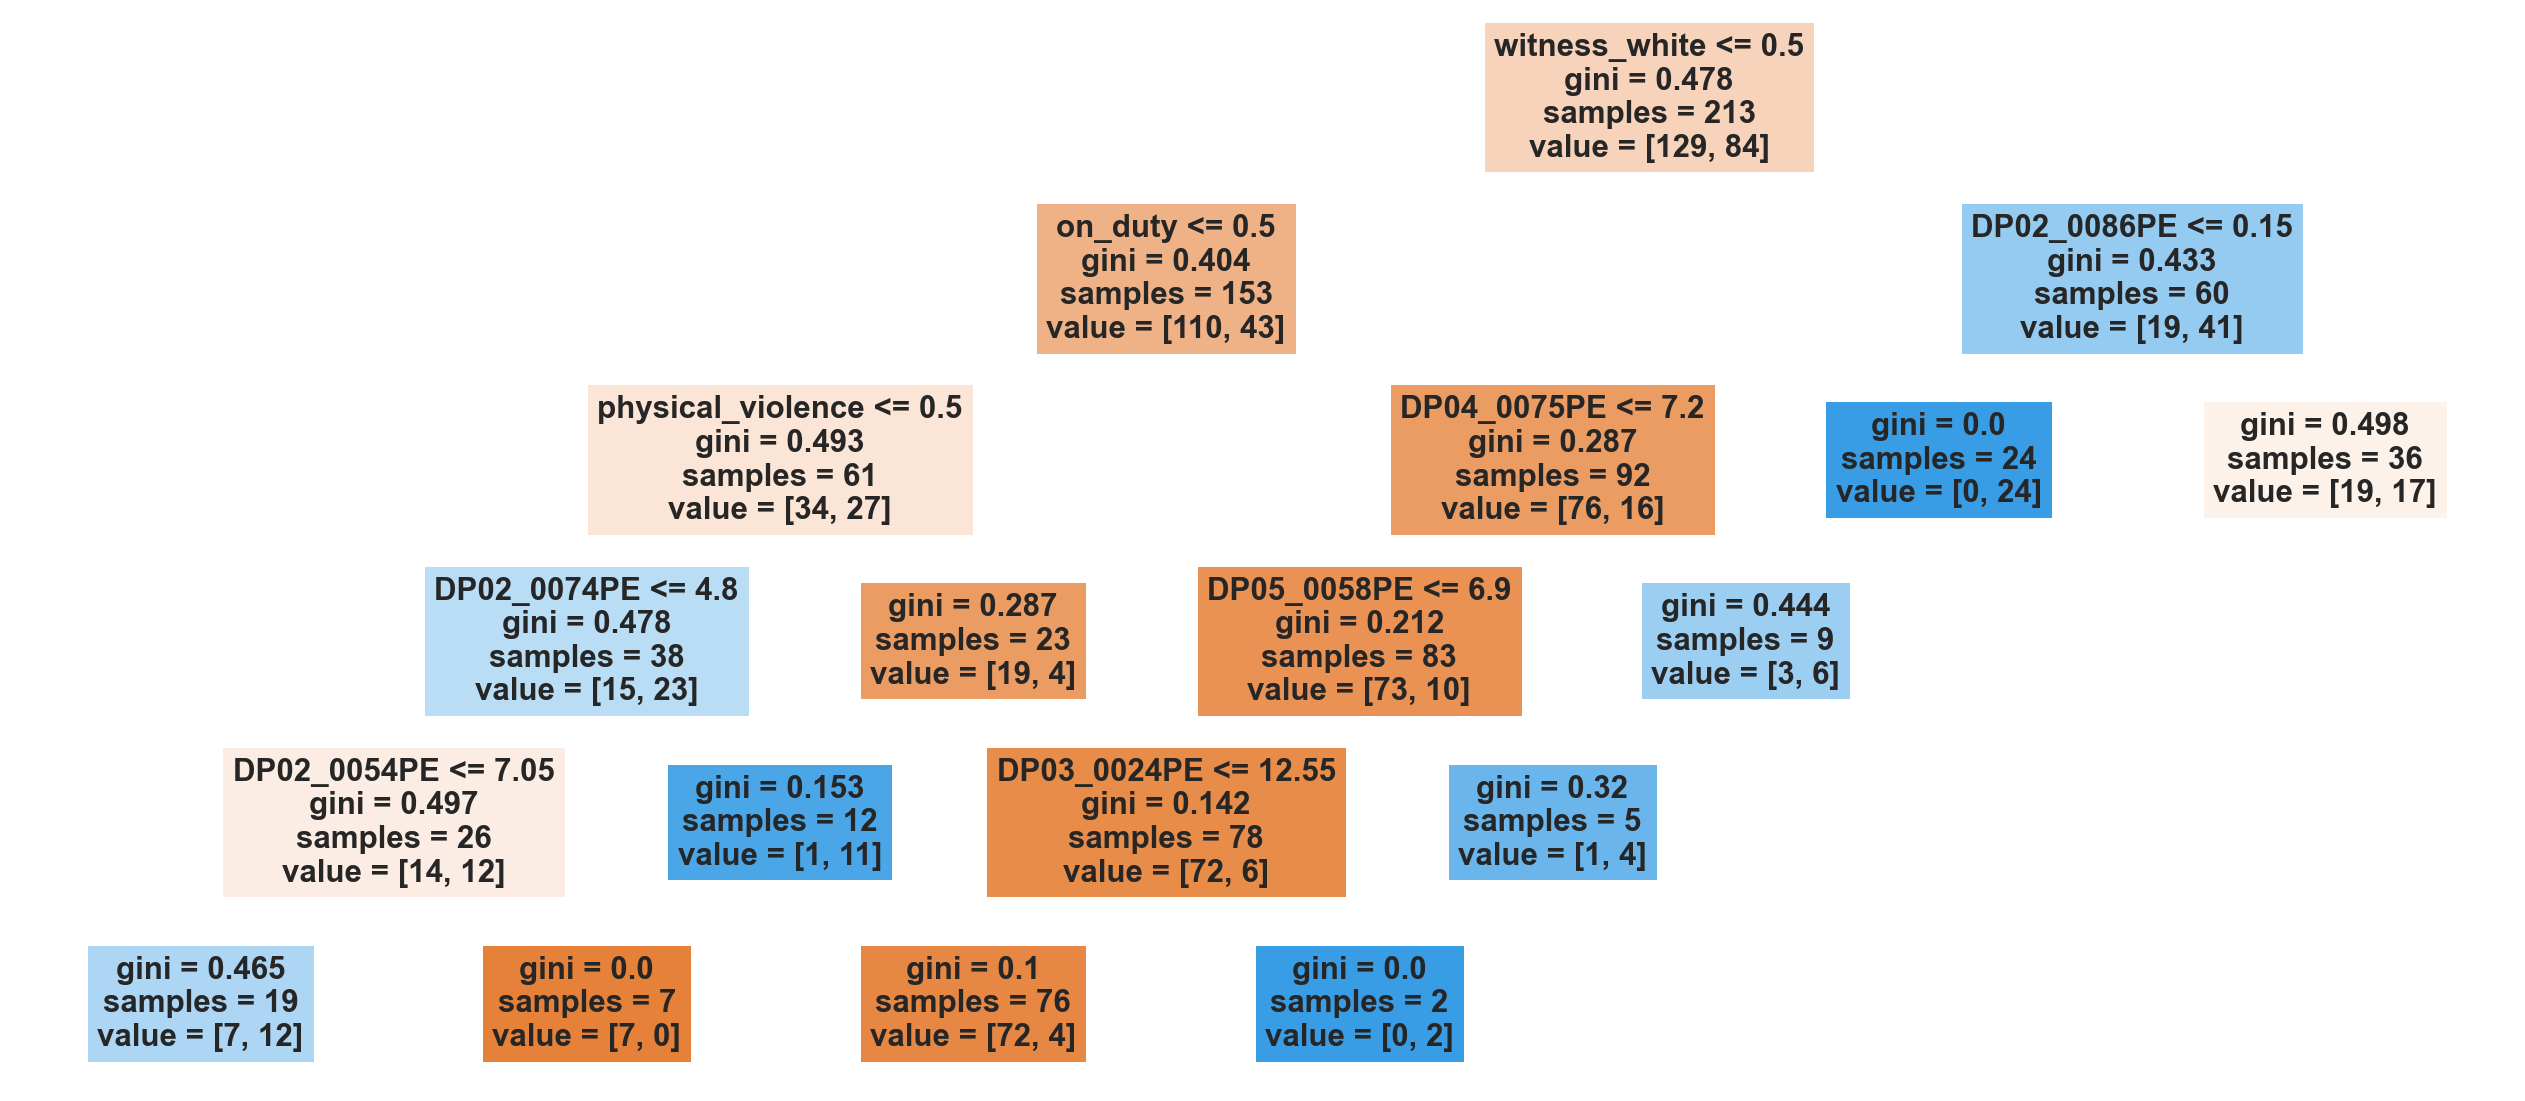

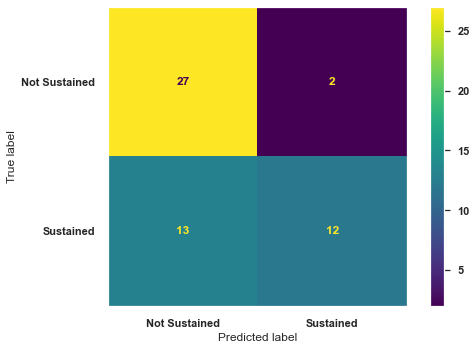

In [229]:
# Decision tree classifier
dt_sub = DecisionTreeClassifier(random_state=1, max_leaf_nodes=10)
dt_sub.fit(X_sub_train, y_train)

# Plotting the tree
fig = plt.figure(figsize=(45,20))
plot_tree = tree.plot_tree(dt_sub, 
                   feature_names=X_sub_train.columns,  
                   filled=True)


dt_sub_pred = dt_sub.predict(X_sub_test)

print(classification_report(y_test, dt_sub_pred, digits = 3))

# Displaying confusion matrix
cm_bc = confusion_matrix(y_test, dt_sub_pred)
display_cm_bc = ConfusionMatrixDisplay(confusion_matrix=cm_bc, display_labels=target_names)
display_cm_bc.plot()
plt.grid(False)

The decision tree using the limited set of predictors performs exactly the same as the one with the whole set of predictors. We do end up with a slightly different tree (e.g. 'on_duty' appears at depth=2), but its performance is no different. 

This also makes sense to an extent, since the features dropped using the VIF approach did not add much variation over what was already captured in other features. Decision Tree uses the important variation in variables to make decisions on where to draw the cuts, so in a sense already looks at the 'most important' features even when we give it the full set of variables.

### 3.4.a - Random Forest, using all features 

              precision    recall  f1-score   support

           0      0.714     0.862     0.781        29
           1      0.789     0.600     0.682        25

    accuracy                          0.741        54
   macro avg      0.752     0.731     0.732        54
weighted avg      0.749     0.741     0.735        54



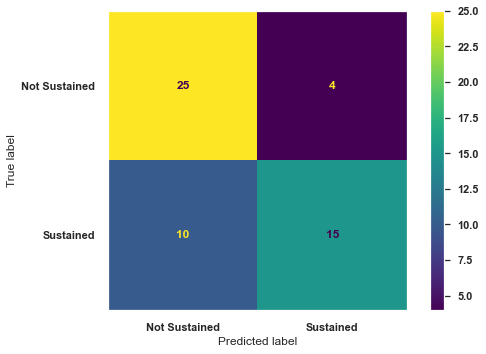

In [230]:
# Random forest classifier, trained on max_depth=10 to reduce runtime
rf_full = RandomForestClassifier(max_depth=10, random_state=1)
rf_full.fit(X_train, y_train)
rf_full_pred = rf_full.predict(X_test)


print(classification_report(y_test, rf_full_pred, digits = 3))

cm = confusion_matrix(y_test,rf_full_pred) 
target_names = ['Not Sustained','Sustained']
display_cm = ConfusionMatrixDisplay(confusion_matrix = cm, display_labels = target_names)
display_cm.plot()
plt.grid(False)

This random forest model on the full set of features does better than KNN and the decision tree from an accuracy perspective. It does better at predicting 'not sustained', and worse at predicting 'sustained' as before, but its performance is better. Perhaps this is because Random Forest has some feature selection inbuilt, it is better at selecting the more important features from the full set.

### 3.4.b - Random forest, using subset of low VIF features

              precision    recall  f1-score   support

           0      0.806     0.862     0.833        29
           1      0.826     0.760     0.792        25

    accuracy                          0.815        54
   macro avg      0.816     0.811     0.812        54
weighted avg      0.816     0.815     0.814        54



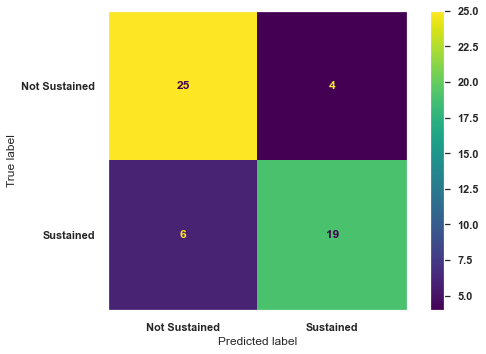

In [231]:
# Random forest classifier, trained on max_depth=10 to reduce runtime
rf_sub = RandomForestClassifier(max_depth=10, random_state=1)
rf_sub.fit(X_sub_train, y_train)
rf_sub_pred = rf_sub.predict(X_sub_test)


print(classification_report(y_test, rf_sub_pred, digits = 3))

cm = confusion_matrix(y_test,rf_sub_pred) 
target_names = ['Not Sustained','Sustained']
display_cm = ConfusionMatrixDisplay(confusion_matrix = cm, display_labels = target_names)
display_cm.plot()
plt.grid(False)

The random forest with low VIF features gives us the best model so far. Accuracy is high at 82%, and it does a similarly good job at predicting both classes. 

Since there are less collinear/irrelevant features for the random forest to choose from, it is likely that the variables that are randomly chosen are of 'better' quality, especially since we have not tuned the model yet. It will be interesting to compare the performance of both versions of random forest when they are tuned, to see if starting with a subet of features still makes a difference.

### 3.5 - Choosing the best model - using AUC/ROC 

To choose the best model more formally, and to account for the sensitivity of different models when changing the decision threshold, we do an AUC/ROC analysis below.

In [232]:
# Getting the predicted probabilities, AUC, and FPR/TPR/Thresholds for all the models we have run so far

# NB - Full
nb_full_probs = nb_full.predict_proba(X_test)

auc_nb_full = roc_auc_score(y_test, nb_full_probs[:, 1])

nb_full_fpr, nb_full_tpr, thresholds = roc_curve(y_test, nb_full_probs[:, 1])

# NB - Sub
nb_sub_probs = nb_sub.predict_proba(X_sub_test)

auc_nb_sub = roc_auc_score(y_test, nb_sub_probs[:, 1])

nb_sub_fpr, nb_sub_tpr, thresholds = roc_curve(y_test, nb_sub_probs[:, 1])

# KNN full
knn_full_probs = knn_full.predict_proba(X_test)

auc_knn_full = roc_auc_score(y_test, knn_full_probs[:, 1])

knn_full_fpr, knn_full_tpr, thresholds = roc_curve(y_test, knn_full_probs[:, 1])

# KNN sub
knn_sub_probs = knn_sub.predict_proba(X_sub_test)

auc_knn_sub = roc_auc_score(y_test, knn_sub_probs[:, 1])

knn_sub_fpr, knn_sub_tpr, thresholds = roc_curve(y_test, knn_sub_probs[:, 1])

# DT full
dt_full_probs = dt_full.predict_proba(X_test)

auc_dt_full = roc_auc_score(y_test, dt_full_probs[:, 1])

dt_full_fpr, dt_full_tpr, thresholds = roc_curve(y_test, dt_full_probs[:, 1])

# DT sub
dt_sub_probs = dt_sub.predict_proba(X_sub_test)

auc_dt_sub = roc_auc_score(y_test, dt_sub_probs[:, 1])

dt_sub_fpr, dt_sub_tpr, thresholds = roc_curve(y_test, dt_sub_probs[:, 1])

# RF full
rf_full_probs = rf_full.predict_proba(X_test)

auc_rf_full = roc_auc_score(y_test, rf_full_probs[:, 1])

rf_full_fpr, rf_full_tpr, thresholds = roc_curve(y_test, rf_full_probs[:, 1])

# RF sub
rf_sub_probs = rf_sub.predict_proba(X_sub_test)

auc_rf_sub = roc_auc_score(y_test, rf_sub_probs[:, 1])

rf_sub_fpr, rf_sub_tpr, thresholds = roc_curve(y_test, rf_sub_probs[:, 1])

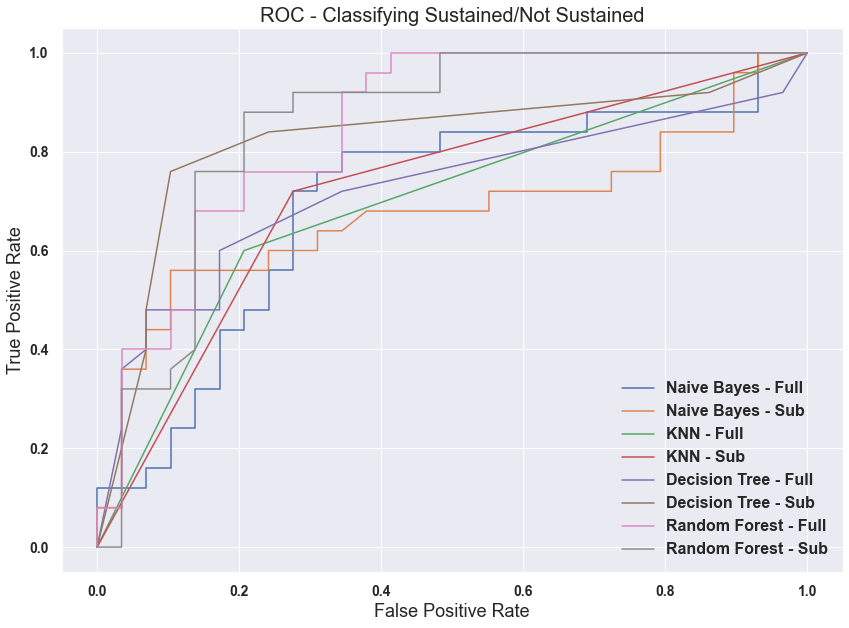

In [233]:
# Plot showing all models
plt.figure(figsize=(14,10))

plt.plot(nb_full_fpr, nb_full_tpr, label="Naive Bayes - Full")
plt.plot(nb_sub_fpr, nb_sub_tpr, label="Naive Bayes - Sub")

plt.plot(knn_full_fpr, knn_full_tpr, label="KNN - Full")
plt.plot(knn_sub_fpr, knn_sub_tpr, label="KNN - Sub")

plt.plot(dt_full_fpr, dt_full_tpr, label="Decision Tree - Full")
plt.plot(dt_sub_fpr, dt_sub_tpr, label="Decision Tree - Sub")

plt.plot(rf_full_fpr, rf_full_tpr, label="Random Forest - Full")
plt.plot(rf_sub_fpr, rf_sub_tpr, label="Random Forest - Sub")



plt.legend(prop={'size':16})
plt.title('ROC - Classifying Sustained/Not Sustained', fontsize=20)
plt.xlabel('False Positive Rate', fontsize=18)
plt.ylabel('True Positive Rate', fontsize=18)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.show()

It is hard to see clearly, but the grey and pink lines refer to the random forest models, and visually appear to extend to the top left corner more clearly. Decision Tree on the subset performs well at higher thresholds (i.e. towards the left side of the graph), but as the thresholds reduce and more observations are classified as positive, the true positive rate reduces more sharply than Random Forest.

In [234]:
# Printing the AUC for all the models

print(f'''
AUC for different models: \n
Naive Bayes Full: {auc_nb_full}\n
Naive Bayes Sub: {auc_nb_sub}\n
KNN Full: {auc_knn_full}\n
KNN Sub: {auc_knn_sub}\n
Decision Tree Full: {auc_dt_full}\n
Decision Tree Sub: {auc_dt_sub}\n
Random Forest Full: {auc_rf_full}\n
Random Forest Sub: {auc_rf_sub}\n
''')


AUC for different models: 

Naive Bayes Full: 0.7006896551724138

Naive Bayes Sub: 0.676551724137931

KNN Full: 0.6965517241379311

KNN Sub: 0.7220689655172413

Decision Tree Full: 0.7227586206896552

Decision Tree Sub: 0.8241379310344827

Random Forest Full: 0.8496551724137931

Random Forest Sub: 0.8558620689655172




These results support the visual findings from the graph - the best models are the Random Forest Full and the Random Forest Sub. We now proceed to tune these models and select the final one.

## 4. Model Tuning, Validation, and Results

In this section, we are tuning both Random Forest (Full) and Random Forest (Sub) because:
1. There is not a significant difference in the AUC between these models
2. Random Forest should have feature selection built in, so it is unclear whether after tuning, starting with a subset would still perform better than letting a random forest run over multiple options for n_estimators

### 4.1.1 - Tuning and validating RF (Full)

{'max_depth': None, 'min_samples_split': 2, 'n_estimators': 100}
              precision    recall  f1-score   support

           0      0.694     0.862     0.769        29
           1      0.778     0.560     0.651        25

    accuracy                          0.722        54
   macro avg      0.736     0.711     0.710        54
weighted avg      0.733     0.722     0.715        54



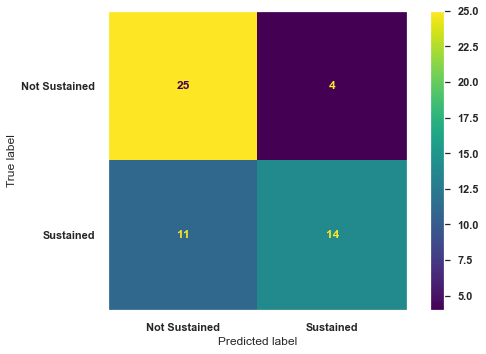

In [235]:
# Parameters to tune - values to test
param_grid = {'n_estimators': [5, 10, 25, 50, 75, 100, 150, 200, 250],
              'min_samples_split': [1, 2, 5, 10, 20],
              'max_depth': [None, 5, 10, 20, 50]}

# Running the grid search, fitting to X_train (full set of predictors)
grid = GridSearchCV(RandomForestClassifier(random_state=1), param_grid, cv=5, scoring='accuracy', refit=True, n_jobs=-1)
grid.fit(X_train, y_train)

# Printing the best parameters after tuning
print(grid.best_params_)

# Getting predicted probabilities from the best mode
rf_tuned_full_pred = grid.predict(X_test)

# Printing the classification report and confusion matrix
print(classification_report(y_test, rf_tuned_full_pred, digits = 3))

cm = confusion_matrix(y_test,rf_tuned_full_pred) 
target_names = ['Not Sustained','Sustained']
display_cm = ConfusionMatrixDisplay(confusion_matrix = cm, display_labels = target_names)
display_cm.plot()
plt.grid(False)

We see that the tuned RF full actually performs slightly worse on the test set than the model run in 3.4.a. This seems a strange result, but is possible when the test set is favourably drawn by chance. Using Cross-Validation subjects the model to more rigorous evaluation by choosing the parameters based on multiple folds. 

The key difference in tuned parameters is in the 'max_depth'. In 3.4.a, we set max_depth=10, which perhaps helped limit 'overfitting' and fit the test set better. 

The accuracy is now 72%, and still it appears 'Not Sustained' is predicted better.

### 4.1.2 - Tuning and validating RF (Sub)

{'max_depth': 10, 'min_samples_split': 2, 'n_estimators': 100}
              precision    recall  f1-score   support

           0      0.806     0.862     0.833        29
           1      0.826     0.760     0.792        25

    accuracy                          0.815        54
   macro avg      0.816     0.811     0.812        54
weighted avg      0.816     0.815     0.814        54



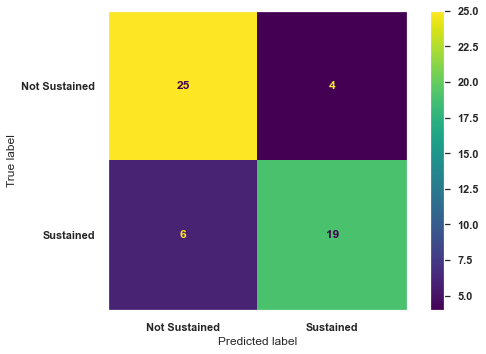

In [236]:
# Parameters to tune - values to test
# Note - having a lower range of n-estimators here makes sense becaues we start with fewer estimators
param_grid = {'n_estimators': [5, 10, 25, 50, 75, 100, 125, 150],
              'min_samples_split': [1, 2, 5, 10, 20],
              'max_depth': [None, 5, 10, 20, 50]}

# Running the grid search
grid = GridSearchCV(RandomForestClassifier(random_state=1), param_grid, cv=5, scoring='accuracy', refit=True, n_jobs=-1)
grid.fit(X_sub_train, y_train)

# Printing the best parameters after tuning
print(grid.best_params_)

# Getting predicted probabilities from the best mode
rf_tuned_sub_pred = grid.predict(X_sub_test)

# Printing the classification report and confusion matrix
print(classification_report(y_test, rf_tuned_sub_pred, digits = 3))

cm = confusion_matrix(y_test,rf_tuned_sub_pred) 
target_names = ['Not Sustained','Sustained']
display_cm = ConfusionMatrixDisplay(confusion_matrix = cm, display_labels = target_names)
display_cm.plot()
plt.grid(False)

Interestingly, for this tuned RF model using only a subset of features, we get exactly the same parameters as we ran in 3.4.b. Hence, the classification results are also the same, with 82% accuracy.

The precision and recall are similar for both classes - that is, we do not perform significantly better on one class. This is a good sign for the model!

### The tuned Random Forest (Sub) model above is our best model for classifying Sustained vs. Not Sustained

### 4.2 - Feature importance and analysis

    Feature Names  Importance
5   witness_white    0.058912
3         on_duty    0.056870
18    DP03_0030PE    0.044351
19    DP03_0045PE    0.042255
17    DP03_0024PE    0.037634
16    DP03_0022PE    0.037617
14    DP02_0084PE    0.036722
8     DP02_0037PE    0.032902
20    DP03_0072PE    0.032067
12    DP02_0060PE    0.031802


Text(0.5, 0, 'Features')

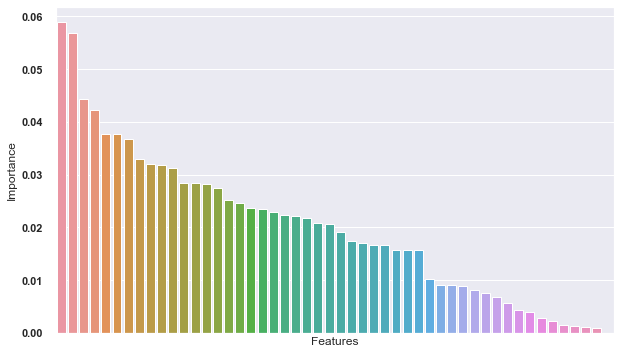

In [237]:
# Fitting RF model to the tuned parameters to get the feature importance method

rf_tuned_sub = RandomForestClassifier(random_state=1,
                                      n_estimators = grid.best_params_['n_estimators'], 
                                      min_samples_split = grid.best_params_['min_samples_split'],
                                      max_depth = grid.best_params_['max_depth']
                                     )

rf_tuned_sub.fit(X_sub_train, y_train)

# Creating a dataset of feature importances
feature_importance = rf_tuned_sub.feature_importances_

feature_df = pd.DataFrame({'Feature Names': X_sub_train.columns, 'Importance': feature_importance})

feature_df.sort_values('Importance', ascending=False, inplace=True)

print(feature_df.head(10))

# Plot 1 - looking at the whole distribution of feature importances, to see how it varies
plt.figure(figsize=(10,6))
sns.barplot(x = 'Feature Names', y = 'Importance', data = feature_df)
plt.xticks([])
plt.xlabel('Features')

**We see that there is a marked difference between the top 2-4 features and the rest.** Hence, below, we focus on the top 5 features.

Text(0, 0.5, '')

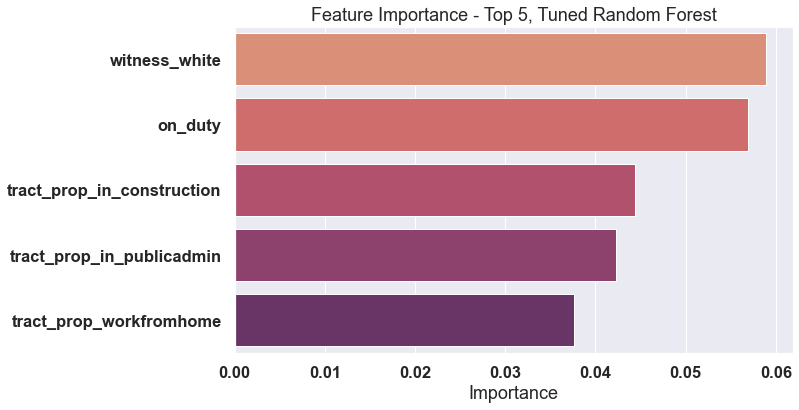

In [238]:
# Plot 2 - Zooming in on top 5 features, labelling nicely
plt.figure(figsize=(10,6))

# Replacing census variables with meaningful names
feature_df.loc[feature_df['Feature Names'] == 'DP03_0030PE', 'Feature Names'] = 'tract_prop_in_construction'
feature_df.loc[feature_df['Feature Names'] == 'DP03_0045PE', 'Feature Names'] = 'tract_prop_in_publicadmin'
feature_df.loc[feature_df['Feature Names'] == 'DP03_0024PE', 'Feature Names'] = 'tract_prop_workfromhome'

# Plotting these features
sns.set(font_scale = 1.5)
sns.barplot(x = 'Importance', y = 'Feature Names', palette="flare", data = feature_df.iloc[:5])
plt.title('Feature Importance - Top 5, Tuned Random Forest')
plt.ylabel('')

The top clear top features are:
1. Whether the witness/victim was White
2. Whether the incident happened when the officer was on duty

The other features, which are less important but still in the top 5, are all to do with working/employment situation. One is the proportion of the tract (i.e. the tract where the case originated), working in construction, followed by those working in public administration, followed by those that work from home. These features are harder to interpret, and could be tied to general measures of income and socioeconomic status.

Below, we try and understand *how* these features are related to the target variable

In [239]:
# Looking at sustained % by whether witness was white, and whether incident happened on duty

print(df_sust.groupby('on_duty').agg({'Finding_Sustained':['count', 'mean']}))

print('\n')

print(df_sust.groupby('witness_white').agg({'Finding_Sustained':['count', 'mean']}))

        Finding_Sustained          
                    count      mean
on_duty                            
0                     134  0.597015
1                     133  0.218045


              Finding_Sustained          
                          count      mean
witness_white                            
0                           194  0.293814
1                            73  0.712329


This gives us clear and interesting findings:
1. 60% of cases that happened off duty had the findings sustained. Only 22% of cases that happened on duty had findings sustained. This is likely because off-duty use of force has fewer reasons that could be used to 'justify' the incident.
2. 71% of cases where the whitness was white led to the complaint being sustained, compared to only 30% when the witness was non-white.

# 5. Conclusions and Discussion

To motivate the overall conclusion, it is helpful to restate the research question. **What dictates the outcome of a complaint? Can we classify these outcomes?**

We saw that a complaint investigation can have several outcomes: sustained, not sustained, unknown, exonerated, unfounded, and no affidavit. It is difficult to classify all of these accurately for a few reasons:
- Ambiguous definitions and blurred lines between categories (e.g. unknown, unfounded)
- Lack of sufficient data points under each category. To be able to successfully classify all of the categories, we would need susbtantially more data points in each category

Limiting the research question to whether we can classify sustained vs. not sustained makes the problem more tractable. It turns out that:
1. Yes, we can classify sustained complaints vs. not sustained complaints with 82% accuracy using a tuned Random Forest classifier
2. The two most important features that dictate the outcome of a complaint are the race of the victim (whether they are white), and whether the incident happened when the officer was on/off-duty 

An overall caveat to this analysis is that it takes the data at face-value in what is anecdotally known to be a very corrupt and biased process. There could well be biases that are introduced because of:
1. Under-reporting of complaints and under-reporting of the outcomes
2. Cases that lead to one finding, but should actually be classified under a different finding (e.g. there was in fact enough evidence, but it was placed under 'Not Sustained' because of bias in the system).


# 6. Future Work

Some avenues for future work are as follows:
1. Attempting to classify 'No Affidavit' vs. the other categories. This is important because 'No Affidavit' is a sign of the victim not following up sufficiently on the complaint. That is, they did not sign an affidavit to take the complaint further. 

2. Testing to see if the proportion of complaints sustained in a given region has some feedback impact on the number of complaints we see from that area; that is, do people get discouraged when they make complaints and nothing happens?

3. Modelling the final outcome from sustained complaints; that is, the severity of the punishment given to the police officer, and which factors influence how severe the punishment is

# References
- https://stats.stackexchange.com/questions/155028/how-to-systematically-remove-collinear-variables-pandas-columns-in-python
- https://stackoverflow.com/questions/41128456/pandas-filter-across-all-columns

# Appendix

## Appendix A - Test model classifying all finding categories

Note: One can see in the models below that attempting to classify all categories leads to small sample sizes per category in the test set, and even leads to '0' estimations. 

In [240]:
# Converting to numeric variable and assigning labels separately
df_all = df.copy()
df_all['Finding'] = df_all['Finding'].astype('category').cat.codes

# Dropping NAs for models to run
df_all.dropna(inplace=True)

y = df_all['Finding']

X = df_all.drop(columns=['CRID', 'Finding'])

X = X.select_dtypes(['number'])

# Split into train and test
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size = 0.20, random_state = 11)                                                      


              precision    recall  f1-score   support

           0      0.000     0.000     0.000        16
           1      0.583     0.177     0.272        79
           2      0.179     0.226     0.200        31
           3      0.039     0.167     0.063        12
           4      0.000     0.000     0.000        53
           5      0.170     0.567     0.262        30

    accuracy                          0.181       221
   macro avg      0.162     0.189     0.133       221
weighted avg      0.259     0.181     0.164       221



C:\Users\mihir\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


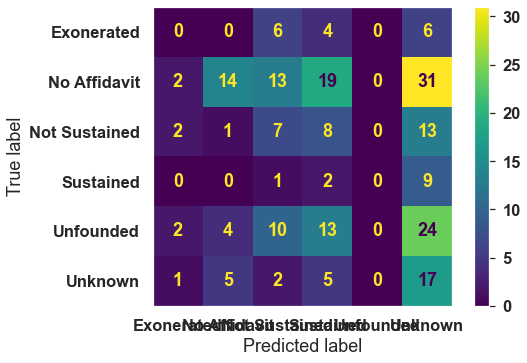

In [241]:
# Naive Bayes

#Defining model
model = GaussianNB()
nb_pred = model.fit(X_train,y_train).predict(X_test) 
print(classification_report(y_test,nb_pred,digits = 3))

#Confusion matrix
cm = confusion_matrix(y_test,nb_pred) 
target_names = ['Exonerated', 'No Affidavit', 'Not Sustained', 'Sustained', 'Unfounded', 'Unknown']
display_cm = ConfusionMatrixDisplay(confusion_matrix = cm, display_labels = target_names)
display_cm.plot()
plt.grid(False)

              precision    recall  f1-score   support

           0      0.714     0.312     0.435        16
           1      0.600     0.722     0.655        79
           2      0.481     0.419     0.448        31
           3      0.083     0.083     0.083        12
           4      0.523     0.434     0.474        53
           5      0.583     0.700     0.636        30

    accuracy                          0.543       221
   macro avg      0.498     0.445     0.455       221
weighted avg      0.543     0.543     0.533       221



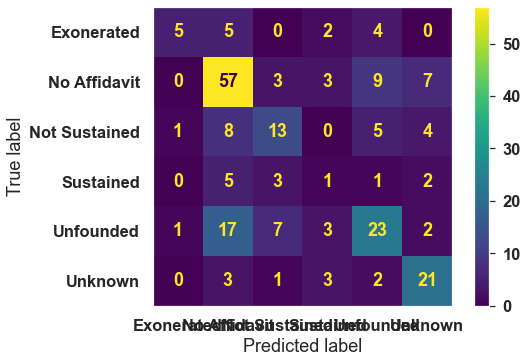

In [242]:
# # Random forest classifier
rf = RandomForestClassifier(n_estimators=500, random_state=1)
rf.fit(X_train, y_train)
y_pred = rf.predict(X_test)


print(classification_report(y_test, y_pred, digits = 3))

cm = confusion_matrix(y_test,y_pred) 
display_cm = ConfusionMatrixDisplay(confusion_matrix = cm, display_labels = target_names)
display_cm.plot()
plt.grid(False)

## Appendix B - Predicting sustained vs. rest

Note: one can see how unbalanced the panels are, and how few results there are in sustained relative to the others, in the confusion matrices below. The model results are not good for the 'Sustained' class.

In [243]:
df_sust_only = pd.get_dummies(df, columns=['Finding'])

df_sust_only.drop(columns=['Finding_Exonerated', 'Finding_No Affidavit', 'Finding_Not Sustained', 'Finding_Unfounded', 'Finding_Unknown'], inplace=True)

df_sust_only.dropna(inplace=True)

y = df_sust_only['Finding_Sustained']

X = df_sust_only.drop(columns=['CRID', 'Finding_Sustained'])

X = X.select_dtypes(['number']) 

# Split into train and test
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size = 0.20, random_state = 11)                                                      


              precision    recall  f1-score   support

           0      0.960     0.579     0.722       209
           1      0.074     0.583     0.131        12

    accuracy                          0.579       221
   macro avg      0.517     0.581     0.427       221
weighted avg      0.912     0.579     0.690       221



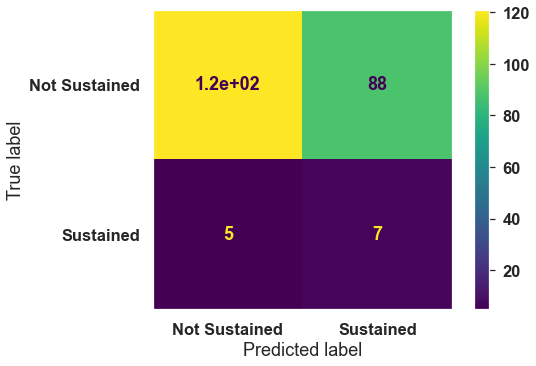

In [244]:
# Naive bayes

#Defining model
model = GaussianNB()
nb_pred = model.fit(X_train,y_train).predict(X_test) 
print(classification_report(y_test,nb_pred,digits = 3))

#Confusion matrix
cm = confusion_matrix(y_test,nb_pred) 
target_names = ['Not Sustained','Sustained']
display_cm = ConfusionMatrixDisplay(confusion_matrix = cm, display_labels = target_names)
display_cm.plot()
plt.grid(False)

              precision    recall  f1-score   support

           0      0.948     0.957     0.952       209
           1      0.100     0.083     0.091        12

    accuracy                          0.910       221
   macro avg      0.524     0.520     0.522       221
weighted avg      0.902     0.910     0.906       221



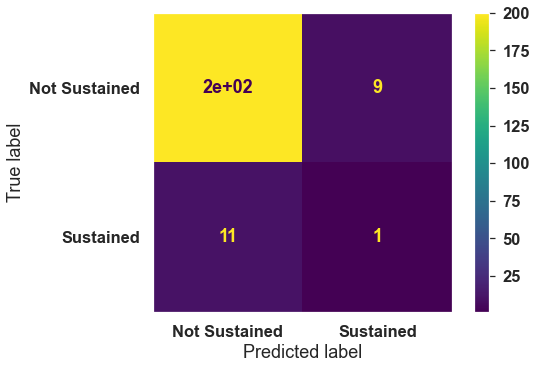

In [245]:
# Random forest classifier
rf = RandomForestClassifier(n_estimators=500, random_state=1)
rf.fit(X_train, y_train)
y_pred = rf.predict(X_test)


print(classification_report(y_test, y_pred, digits = 3))

cm = confusion_matrix(y_test,y_pred) 
target_names = ['Not Sustained','Sustained']
display_cm = ConfusionMatrixDisplay(confusion_matrix = cm, display_labels = target_names)
display_cm.plot()
plt.grid(False)